<a href="https://colab.research.google.com/github/pkraman06/Coursera_project/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.8 MB/s eta 0:00:00
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-bym1ca1n
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-bym1ca1n
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.24
    Uninstalling albucore-0.0.24:
      Successfully uninstalled albucore-0.0.24
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires albucore==0.0.24, but you have albucore 0.0.28 which is incompatible.

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 44.92 MiB/s, done.
Resolving deltas: 100% (3/3), done.


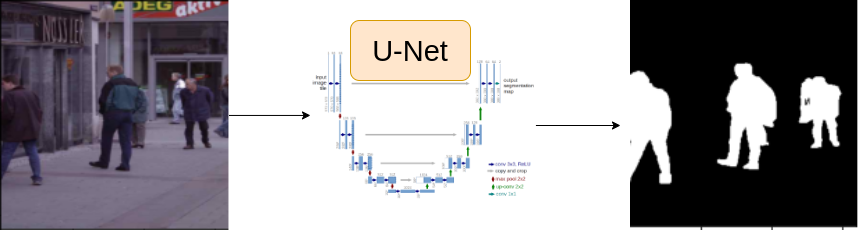

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [25]:
CSV_FILE="/content/Human-Segmentation-Dataset-master/train.csv"
DATA_DIR="/content"

DEVICE="cuda"

EPOCHS=25
LR=0.003
BATCH_SIZE=16

IMAGE_SIZE = 320
ENCODER="timm-efficientnet-b0"
WEIGHTS="imagenet"

In [6]:
df=pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row=df.iloc[0]
image_path=row.images
mask_path=row.masks

image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0



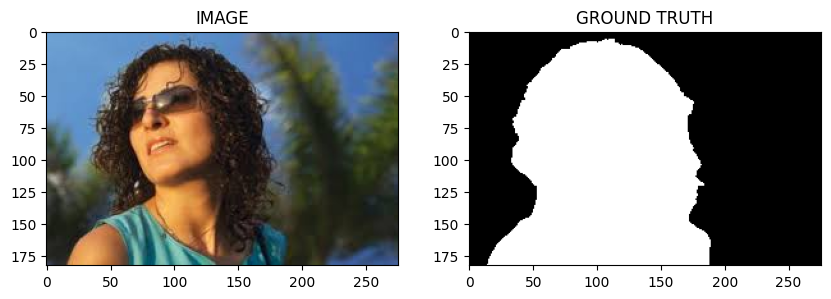

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
# function for training dataset augmentation
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
  ])


# function for validation dataset augmentation
def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
  ])

# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):

  # the initial method for the dataframe and augmentation
  def __init__(self, df, augmentations = None):
    self.df = df
    self.augmentations = augmentations

  # length of the dataframe
  def __len__(self):
    return len(self.df)

  # get item the image attributes
  def __getitem__(self, index):
    row = self.df.iloc[index]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
    mask = np.expand_dims(mask, axis = -1)

    if image.shape != mask.shape:
            # Resize or crop either image or mask to match dimensions
            # Example:
            image = cv2.resize(image, (mask.shape[1], mask.shape[0]))

    data = self.augmentations(image=image, mask=mask)
    image = data['image']
    mask = data['mask']

    # (h, w, c) -> (c, h, w)

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)


    # convert from numpy to tensor
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) /255.0)

    return image, mask

In [14]:
# now call the SegmentationDataset class to augment the train_df and valid_df
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


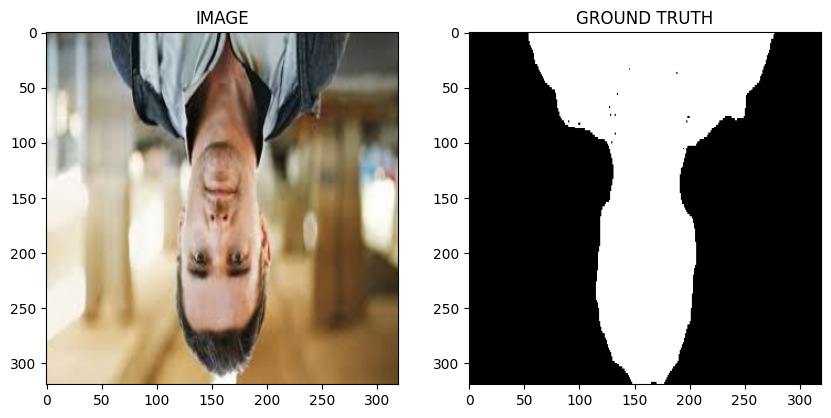

In [16]:
idx=32

image,mask=trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader = DataLoader(validset,batch_size=BATCH_SIZE)

In [19]:
print(f"total no.of batches in trainloader : {len(trainloader)}")
print(f"total no.of batches in validloader : {len(validloader)}")

total no.of batches in trainloader : 15
total no.of batches in validloader : 4


In [20]:
for image, mask in trainloader:
   break

print(f"shape of one image is : {image.shape}")
print(f"shape of one mask is : {mask.shape}")

shape of one image is : torch.Size([16, 3, 320, 320])
shape of one mask is : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import  DiceLoss


In [22]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, mask = None):

    logits = self.arc(images)

    if mask is not None:
      loss1 = DiceLoss(mode="binary")(logits, mask)
      loss2 = nn.BCEWithLogitsLoss()(logits, mask)
      return logits, loss1 + loss2

    return logits

In [26]:
model=SegmentationModel()
model.to(DEVICE);

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

# Task 7 : Create Train and Validation Function

In [27]:
def train_fn(model, dataloader, optimizer):
  model.train()
  train_loss = 0
  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()
    logits, loss = model(images, masks)
    optimizer.step()
    train_loss += loss.item()

    total_loss = train_loss / len(dataloader)
  return total_loss

In [28]:
def eval_fn(model, dataloader):
  model.eval()
  total_loss = 0

  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()
  return total_loss / len(dataloader)

# Task 8 : Train Model

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [31]:
best_valid_loss = np.inf

for epoch in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'best_model.pth')
    print("SAVED-MODEL")
    best_valid_loss = valid_loss

  print(f"EPOCH : {epoch+1} | Train Loss : {train_loss} | Valid Loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  5.99it/s]


SAVED-MODEL
EPOCH : 1 | Train Loss : 1.457196553548177 | Valid Loss : 1.4744254648685455


100%|██████████| 4/4 [00:00<00:00,  6.13it/s]


SAVED-MODEL
EPOCH : 2 | Train Loss : 1.4574745098749797 | Valid Loss : 1.421727478504181


100%|██████████| 4/4 [00:00<00:00,  6.23it/s]


EPOCH : 3 | Train Loss : 1.4637340386708577 | Valid Loss : 1.443947196006775


100%|██████████| 4/4 [00:00<00:00,  5.62it/s]


EPOCH : 4 | Train Loss : 1.4595735470453899 | Valid Loss : 1.4516354501247406


100%|██████████| 4/4 [00:00<00:00,  6.12it/s]


EPOCH : 5 | Train Loss : 1.4575495958328246 | Valid Loss : 1.449697345495224


100%|██████████| 4/4 [00:00<00:00,  6.18it/s]


EPOCH : 6 | Train Loss : 1.4591452360153199 | Valid Loss : 1.456219494342804


100%|██████████| 4/4 [00:00<00:00,  5.70it/s]


EPOCH : 7 | Train Loss : 1.4560966809590659 | Valid Loss : 1.4573506712913513


100%|██████████| 4/4 [00:00<00:00,  6.09it/s]


EPOCH : 8 | Train Loss : 1.4569366772969563 | Valid Loss : 1.4566935896873474


100%|██████████| 4/4 [00:00<00:00,  6.07it/s]


EPOCH : 9 | Train Loss : 1.4588170131047566 | Valid Loss : 1.4595155119895935


100%|██████████| 4/4 [00:00<00:00,  6.17it/s]


EPOCH : 10 | Train Loss : 1.4508551994959513 | Valid Loss : 1.4581710696220398


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


EPOCH : 11 | Train Loss : 1.4571500062942504 | Valid Loss : 1.451532244682312


100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


EPOCH : 12 | Train Loss : 1.4543542544047037 | Valid Loss : 1.4517019987106323


100%|██████████| 4/4 [00:00<00:00,  6.14it/s]


EPOCH : 13 | Train Loss : 1.4636897325515748 | Valid Loss : 1.4555459320545197


100%|██████████| 4/4 [00:00<00:00,  6.10it/s]


EPOCH : 14 | Train Loss : 1.4531341632207235 | Valid Loss : 1.451962172985077


100%|██████████| 4/4 [00:00<00:00,  6.02it/s]


EPOCH : 15 | Train Loss : 1.4584811210632325 | Valid Loss : 1.4515272080898285


100%|██████████| 4/4 [00:00<00:00,  6.03it/s]


EPOCH : 16 | Train Loss : 1.454969882965088 | Valid Loss : 1.4547251462936401


100%|██████████| 4/4 [00:00<00:00,  6.15it/s]


EPOCH : 17 | Train Loss : 1.4482758522033692 | Valid Loss : 1.4544917941093445


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


EPOCH : 18 | Train Loss : 1.4576889753341675 | Valid Loss : 1.4569291472434998


100%|██████████| 4/4 [00:00<00:00,  6.07it/s]


EPOCH : 19 | Train Loss : 1.464076813062032 | Valid Loss : 1.4569384157657623


100%|██████████| 4/4 [00:00<00:00,  6.17it/s]


EPOCH : 20 | Train Loss : 1.4548032681147258 | Valid Loss : 1.457988679409027


100%|██████████| 4/4 [00:00<00:00,  6.11it/s]


EPOCH : 21 | Train Loss : 1.4554552634557087 | Valid Loss : 1.45549076795578


100%|██████████| 4/4 [00:00<00:00,  5.91it/s]


EPOCH : 22 | Train Loss : 1.4597628911336262 | Valid Loss : 1.4534781873226166


100%|██████████| 4/4 [00:00<00:00,  6.05it/s]


EPOCH : 23 | Train Loss : 1.4576751073201497 | Valid Loss : 1.4553995728492737


100%|██████████| 4/4 [00:00<00:00,  6.05it/s]


EPOCH : 24 | Train Loss : 1.456355881690979 | Valid Loss : 1.4544505774974823


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]

EPOCH : 25 | Train Loss : 1.4587764263153076 | Valid Loss : 1.4597029387950897


# Task 9 : Inference

In [34]:
def inference(indx):
  idx = indx

  model.load_state_dict(torch.load('/content/best_model.pth'))

  image, mask = validset[idx]


  logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)
  pred_mask = torch.sigmoid(logits_mask)
  pred_mask = (pred_mask > 0.5)*1.0

  return helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

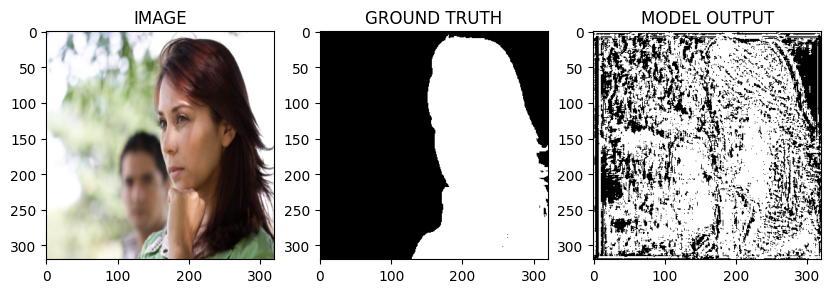

In [35]:
inference(3)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya